In [34]:
# dataDir ="C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/location-2"
dataDir = "D:/desktop_alternative/buetav/behavior-hypotheses-main/location-2"
# dataDir = "/home/ababil/BUET/AV/location-2"
# dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [35]:
# exec(open('init_notebook.py').read())
# exec(open('C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/src/notebooks/init_notebook.py').read())
exec(open('D:/desktop_alternative/buetav/behavior-hypotheses-main/src/notebooks/init_notebook.py').read())

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [38]:
sceneId = 210
sceneId2 = 211
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
pedDf2 = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId2}-pedestrians.csv"))
# otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

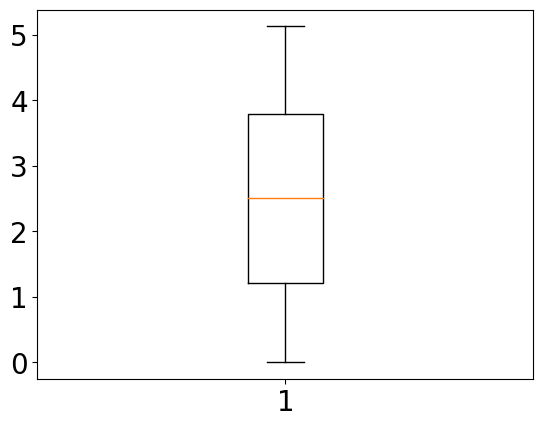

{'whiskers': [<matplotlib.lines.Line2D at 0x20ec0cd4450>,
 'caps': [<matplotlib.lines.Line2D at 0x20ec0cb6f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x20ec0cd4290>],
 'medians': [<matplotlib.lines.Line2D at 0x20ec0cb44d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20ec081cd50>],
 'means': []}

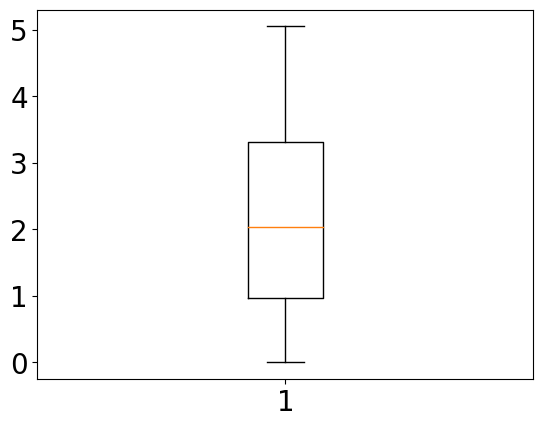

In [39]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        fps=10,
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        # xAccCol='sceneXAcceleration',
        # yAccCol='sceneYAcceleration',
        # accelerationCol='acceleration'
        
    
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    # minAcceleration = -10.0,
    # maxAcceleration = 10.0,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# transformer.deriveAcceleration(pedDf)

transformer.deriveSpeed(pedDf2)
transformer.deriveDisplacements(pedDf2)
# transformer.deriveAcceleration(pedDf2)

plt.boxplot(pedDf['displacementY'])
plt.show()
plt.boxplot(pedDf2['displacementY'])

In [40]:
xCol="sceneX"
yCol="sceneY"
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate180(trackDf,xCol,yCol)
        # X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


11101

In [41]:
# max and min values of speed
print(cleanPedDf['speed'].max())
print(cleanPedDf['speed'].min())



1.295494983587356
0.037856637462931705


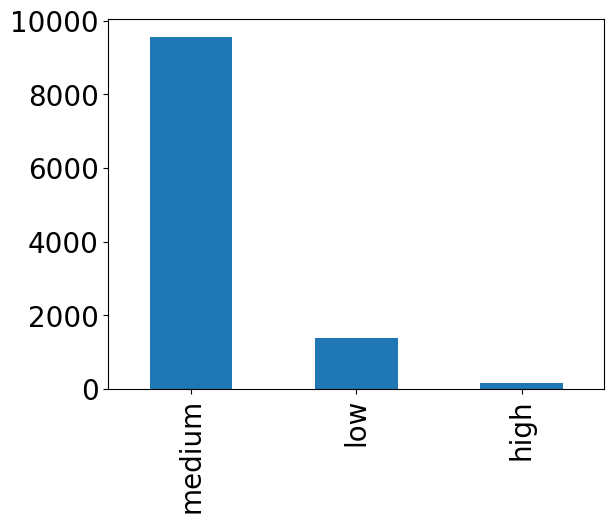

In [42]:
# categorize speed into 3 bins
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=3, labels=['low', 'medium', 'high'])
cleanPedDf['speedCategory'].value_counts()
cleanPedDf['speedCategory'].value_counts().plot(kind='bar')
plt.show()

In [43]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY,speedCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854,medium
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691,medium
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374,medium
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065,medium
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25930,29,28395,29542,210,5.0,0.237537,2.188855,0.185355,-0.517096,-0.058848,0.022410,0.549313,1.580843,4.653339,-1.580843,4.653339,medium
25931,29,28397,29542,210,5.0,0.198530,2.291690,0.195039,-0.514172,-0.048420,-0.014621,0.549921,1.619851,4.756174,-1.619851,4.756174,medium
25932,29,28399,29542,210,5.0,0.156704,2.395122,0.209126,-0.517159,-0.070435,0.014934,0.557841,1.661676,4.859606,-1.661676,4.859606,medium
25933,29,28401,29542,210,5.0,0.113808,2.498140,0.214482,-0.515092,-0.026781,-0.010337,0.557962,1.704572,4.962624,-1.704572,4.962624,medium


In [44]:
# min and max of low, medium and high speed
print(cleanPedDf[cleanPedDf['speedCategory'] == 'low']['speed'].min())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'low']['speed'].max())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'medium']['speed'].min())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'medium']['speed'].max())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'high']['speed'].min())
print(cleanPedDf[cleanPedDf['speedCategory'] == 'high']['speed'].max())


0.037856637462931705
0.45706150570793025
0.4571007164728592
0.8751310944652783
0.8763146837751948
1.295494983587356


In [45]:
# drop the speed category column
cleanPedDf.drop(columns=['speedCategory'], inplace=True)

In [46]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25930,29,28395,29542,210,5.0,0.237537,2.188855,0.185355,-0.517096,-0.058848,0.022410,0.549313,1.580843,4.653339,-1.580843,4.653339
25931,29,28397,29542,210,5.0,0.198530,2.291690,0.195039,-0.514172,-0.048420,-0.014621,0.549921,1.619851,4.756174,-1.619851,4.756174
25932,29,28399,29542,210,5.0,0.156704,2.395122,0.209126,-0.517159,-0.070435,0.014934,0.557841,1.661676,4.859606,-1.661676,4.859606
25933,29,28401,29542,210,5.0,0.113808,2.498140,0.214482,-0.515092,-0.026781,-0.010337,0.557962,1.704572,4.962624,-1.704572,4.962624


In [47]:
# categorize speed into 3 bins, less than 0.5 is low, 0.5 to 1.0 is medium, more than 1.0 is high
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])

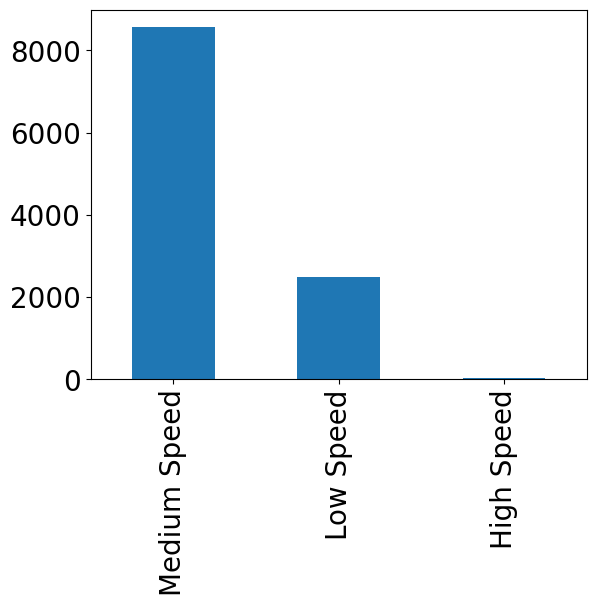

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY,speedCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854,Low Speed
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691,Low Speed
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374,Low Speed
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065,Low Speed
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082,Low Speed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25930,29,28395,29542,210,5.0,0.237537,2.188855,0.185355,-0.517096,-0.058848,0.022410,0.549313,1.580843,4.653339,-1.580843,4.653339,Medium Speed
25931,29,28397,29542,210,5.0,0.198530,2.291690,0.195039,-0.514172,-0.048420,-0.014621,0.549921,1.619851,4.756174,-1.619851,4.756174,Medium Speed
25932,29,28399,29542,210,5.0,0.156704,2.395122,0.209126,-0.517159,-0.070435,0.014934,0.557841,1.661676,4.859606,-1.661676,4.859606,Medium Speed
25933,29,28401,29542,210,5.0,0.113808,2.498140,0.214482,-0.515092,-0.026781,-0.010337,0.557962,1.704572,4.962624,-1.704572,4.962624,Medium Speed


In [48]:
cleanPedDf['speedCategory'].value_counts()
cleanPedDf['speedCategory'].value_counts().plot(kind='bar')
plt.show()
cleanPedDf

In [49]:
# min and max of acceleration
# print(cleanPedDf['acceleration'].min())
# print(cleanPedDf['acceleration'].max())

In [50]:
# min and max of sceneYAceleration
print(cleanPedDf['sceneYAcceleration'].min())
print(cleanPedDf['sceneYAcceleration'].max())

-0.3380669706007375
0.3404802056240619


In [51]:
# min and max of positive sceneYAceleration
print(cleanPedDf[cleanPedDf['sceneYAcceleration'] > 0]['sceneYAcceleration'].min())
print(cleanPedDf[cleanPedDf['sceneYAcceleration'] > 0]['sceneYAcceleration'].max())

5.032627292678171e-06
0.3404802056240619


In [52]:
# categorize sceneYAcceleration into 6 bins
# 3 positive bins, 3 negative bins
# -10 to -.2, -.2 to -.1, -.1 to 0, 0 to .1, .1 to .2, .2 to 10
cleanPedDf['sceneYAccelerationCategory'] = pd.cut(cleanPedDf['sceneYAcceleration'], 
                                                  bins=[-10, -.2, -.1, 0, .1, .2, 10], 
                                                  labels=['High Deceleration', 'Medium Deceleration', 'Low Deceleration', 'Low Acceleration', 'Medium Acceleration', 'High Acceleration'])


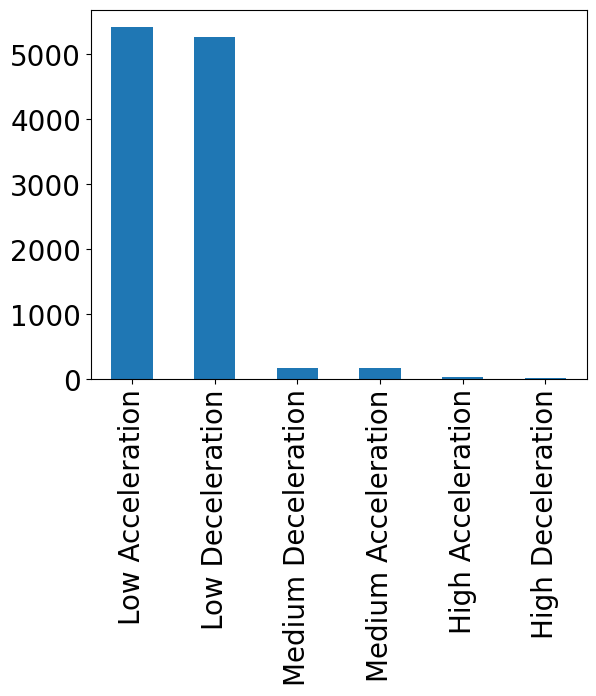

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY,speedCategory,sceneYAccelerationCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854,Low Speed,Low Deceleration
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691,Low Speed,Low Acceleration
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374,Low Speed,Low Deceleration
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065,Low Speed,Low Deceleration
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082,Low Speed,Low Acceleration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25930,29,28395,29542,210,5.0,0.237537,2.188855,0.185355,-0.517096,-0.058848,0.022410,0.549313,1.580843,4.653339,-1.580843,4.653339,Medium Speed,Low Acceleration
25931,29,28397,29542,210,5.0,0.198530,2.291690,0.195039,-0.514172,-0.048420,-0.014621,0.549921,1.619851,4.756174,-1.619851,4.756174,Medium Speed,Low Deceleration
25932,29,28399,29542,210,5.0,0.156704,2.395122,0.209126,-0.517159,-0.070435,0.014934,0.557841,1.661676,4.859606,-1.661676,4.859606,Medium Speed,Low Acceleration
25933,29,28401,29542,210,5.0,0.113808,2.498140,0.214482,-0.515092,-0.026781,-0.010337,0.557962,1.704572,4.962624,-1.704572,4.962624,Medium Speed,Low Deceleration


In [53]:
cleanPedDf['sceneYAccelerationCategory'].value_counts()
cleanPedDf['sceneYAccelerationCategory'].value_counts().plot(kind='bar')
plt.show()
cleanPedDf

In [54]:
# plot a heatmap of sceneYAccelerationCategory vs speedCategory
# create a pivot table


<AxesSubplot: >

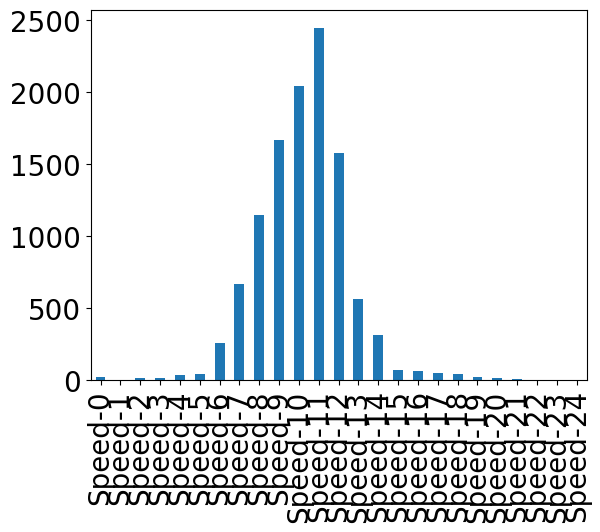

In [55]:
# make 25 bins for speed
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=25, labels=[f"Speed-{i}" for i in range(25)])
cleanPedDf['speedCategory'].value_counts()
cleanPedDf['speedCategory'].value_counts(sort=False).plot(kind='bar')

11101
5625


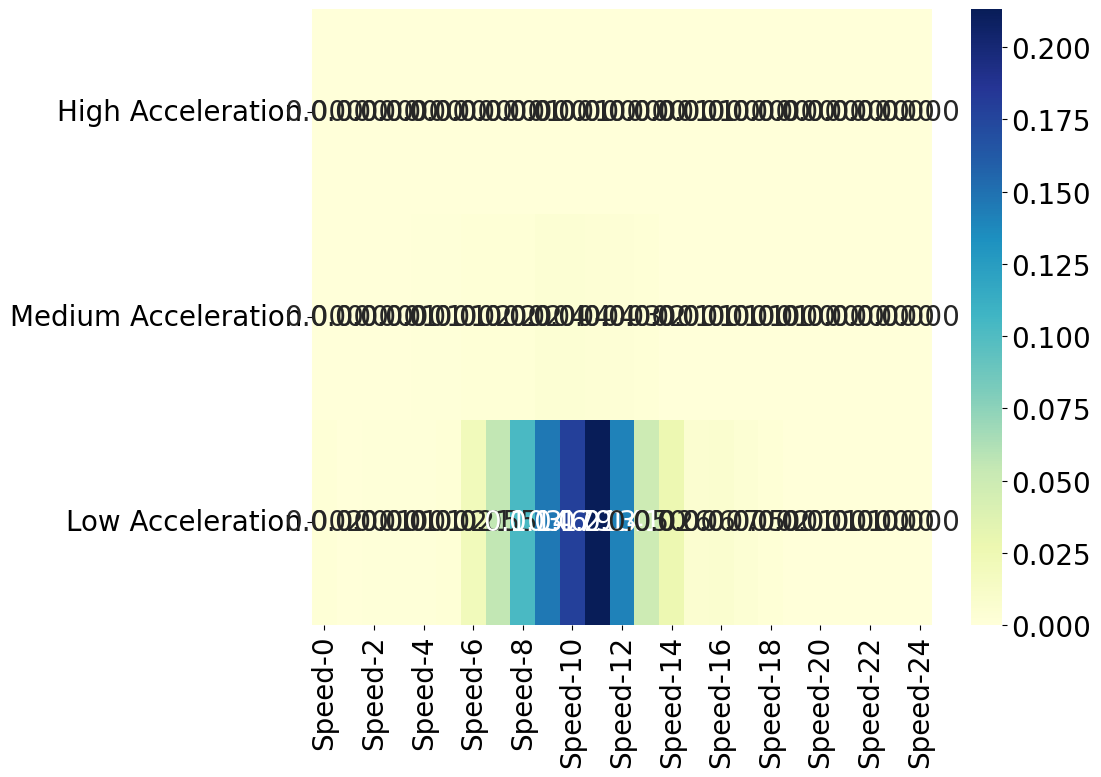

In [56]:
# plot a heatmap
pivot = pd.pivot_table(cleanPedDf, values='uniqueTrackId', index=['sceneYAccelerationCategory'], columns=['speedCategory'], aggfunc='count')
pivot

total = pivot.sum().sum()
print(total)

# plt.figure(figsize=(18, 16))
# sns.heatmap(pivot, annot=True, fmt="d")


plt.rc('font', size=20)
plt.rc('axes', labelsize=10)
# plt.figure(figsize=(18, 16))

# reverse the order of rows
pivot = pivot.iloc[::-1]
# sns.heatmap(pivot/total, annot=True, fmt=".3f", cmap='YlGnBu')

# # remove the x and y labels
# plt.xlabel('')
# plt.ylabel('')

# plt.xlabel('Speed Category')
# plt.ylabel('Acceleration Category')

# plt.show()


pivot = pivot.iloc[:3]
pivot

total = pivot.sum().sum()
print(total)

plt.rc('font', size=20)
plt.rc('axes', labelsize=10)
plt.figure(figsize=(10,8))

# reverse the order of rows
# pivot = pivot.iloc[::-1]
sns.heatmap(pivot/total, annot=True, fmt=".3f", cmap='YlGnBu')

# remove the x and y labels
plt.xlabel('')
plt.ylabel('')

# plt.xlabel('Speed Category')
# plt.ylabel('Acceleration Category')

plt.show()

In [57]:
# take the first 3 rows of the pivot table and plot the same heatmap


In [58]:
# cleanPedDf_copy = cleanPedDf.copy()
# # cleanPedDf_copy.head(10)

# NO_OF_CATEGORY = 3

# MIN_SPEED = cleanPedDf_copy["speed"].min()
# MAX_SPEED = cleanPedDf_copy["speed"].max()

# def assign_category(value, min_value, max_value, no_of_category = NO_OF_CATEGORY):
#     bucket_range = math.ceil(max_value - min_value) / no_of_category
    
#     for i in range(no_of_category):
#         if ((i-1)*bucket_range < value) and ((i*bucket_range) >= value):
#                 return i
    
    
# # cleanPedDf_copy["Bucket"] = cleanPedDf_copy["speed"].apply(assign_category(MIN_SPEED, MAX_SPEED))
# cleanPedDf_copy["Bucket"] = assign_category(cleanPedDf_copy["speed"], min_speed, max_value, NO_OF_CATEGORY)

# cleanPedDf_copy.head(10)

11101
5476


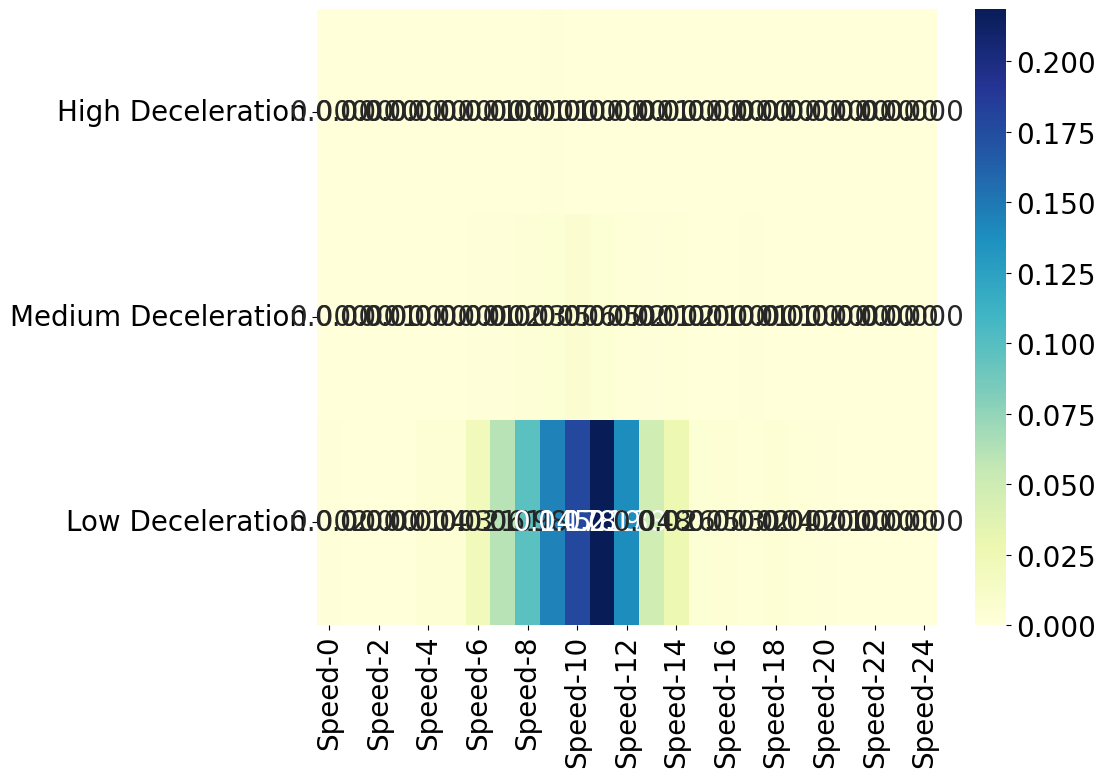

In [59]:
pivot = pd.pivot_table(cleanPedDf, values='uniqueTrackId', index=['sceneYAccelerationCategory'], columns=['speedCategory'], aggfunc='count')
pivot

total = pivot.sum().sum()
print(total)

# plt.figure(figsize=(18, 16))
# sns.heatmap(pivot, annot=True, fmt="d")


plt.rc('font', size=20)
plt.rc('axes', labelsize=10)
# plt.figure(figsize=(18, 16))

# reverse the order of rows
# pivot = pivot.iloc[::-1]
# sns.heatmap(pivot/total, annot=True, fmt=".3f", cmap='YlGnBu')

# # remove the x and y labels
# plt.xlabel('')
# plt.ylabel('')

# plt.xlabel('Speed Category')
# plt.ylabel('Acceleration Category')

# plt.show()


pivot = pivot.iloc[:3]
pivot

total = pivot.sum().sum()
print(total)

plt.rc('font', size=20)
plt.rc('axes', labelsize=10)
plt.figure(figsize=(10,8))

# reverse the order of rows
# pivot = pivot.iloc[::-1]
sns.heatmap(pivot/total, annot=True, fmt=".3f", cmap='YlGnBu')

# remove the x and y labels
plt.xlabel('')
plt.ylabel('')

# plt.xlabel('Speed Category')
# plt.ylabel('Acceleration Category')

plt.show()

In [60]:
cleanPedDf_copy = cleanPedDf.copy()
cleanPedDf_copy.head(10)
print(len(cleanPedDf_copy), len(cleanPedDf))

NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

# Example usage:
min_value = cleanPedDf_copy["speed"].min()
max_value = cleanPedDf_copy["speed"].max()

print("Min:", min_value, "Max:", max_value)

value_range = max_value - min_value
category_range = value_range / NO_OF_CATEGORY
print(f"Range in one bucket: {category_range}")

# # Assuming cleanPedDf_copy is your DataFrame
# cleanPedDf_copy["Bucket"] = assign_category(cleanPedDf_copy["speed"], NO_OF_CATEGORY)
# print("Buckets:", cleanPedDf_copy["Bucket"].min(), cleanPedDf_copy["Bucket"].max())

cleanPedDf_copy.head(10)


11101 11101
Min: 0.037856637462931705 Max: 1.295494983587356
Range in one bucket: 0.4192127820414748


,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY,speedCategory,sceneYAccelerationCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854,Speed-8,Low Deceleration
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691,Speed-8,Low Acceleration
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374,Speed-8,Low Deceleration
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065,Speed-9,Low Deceleration
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082,Speed-9,Low Acceleration
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,-0.670135,-1.967831,Speed-8,Low Acceleration
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,-0.679707,-1.870670,Speed-8,Low Acceleration
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,-0.690215,-1.773153,Speed-8,Low Deceleration
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,-0.701232,-1.674626,Speed-9,Low Deceleration
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,-0.712428,-1.575365,Speed-9,Low Deceleration


In [61]:
# Find the minimum and maximum values
min_value = cleanPedDf_copy["speed"].min()
max_value = cleanPedDf_copy["speed"].max()

# Print the results
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Minimum: 0.037856637462931705
Maximum: 1.295494983587356


In [62]:
# Boolean indexing to filter rows
selected_rows = cleanPedDf_copy[cleanPedDf_copy["speed"] < category_range]

# Print the selected rows
selected_rows

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY,speedCategory,sceneYAccelerationCategory
500,18,8381,18134,210,5.0,-0.051990,-1.392187,0.125315,0.395367,0.082562,0.018767,0.414752,1.081695,3.886836,0.051990,1.392187,Speed-7,Low Acceleration
501,18,8383,18134,210,5.0,-0.073623,-1.472103,0.108167,0.399577,0.085740,-0.021048,0.413959,1.103328,3.966751,0.073623,1.472103,Speed-7,Low Deceleration
502,18,8385,18134,210,5.0,-0.091809,-1.553488,0.090929,0.406926,0.086190,-0.036746,0.416962,1.121514,4.048136,0.091809,1.553488,Speed-7,Low Deceleration
599,18,10279,18168,210,5.0,1.460623,-0.936577,-0.021844,-0.415073,-0.025870,-0.021530,0.415648,0.137909,1.542124,0.137909,1.542124,Speed-7,Low Deceleration
600,18,10281,18168,210,5.0,1.464019,-0.854467,-0.016980,-0.410547,-0.024318,-0.022632,0.410898,0.141305,1.624233,0.141305,1.624233,Speed-7,Low Deceleration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24327,29,9328,29184,210,5.0,0.967348,2.337421,-0.180533,-0.238962,-0.025819,0.030887,0.299491,0.814268,4.785148,-0.814268,4.785148,Speed-5,Low Acceleration
24328,29,9330,29184,210,5.0,1.002205,2.387385,-0.174283,-0.249823,-0.031253,0.054309,0.304608,0.779412,4.835112,-0.779412,4.835112,Speed-5,Low Acceleration
24329,29,9332,29184,210,5.0,1.035539,2.440297,-0.166668,-0.264560,-0.038072,0.073682,0.312682,0.746078,4.888024,-0.746078,4.888024,Speed-5,Low Acceleration
24330,29,9334,29184,210,5.0,1.066993,2.496735,-0.157273,-0.282187,-0.046976,0.088134,0.323054,0.714623,4.944462,-0.714623,4.944462,Speed-5,Low Acceleration


In [63]:
# Find the minimum and maximum values
min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()

# Print the results
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Minimum: -0.3380669706007375
Maximum: 0.3404802056240619


In [64]:
# def assign_acc_category(acc):
#     if acc < 0.1:
#         # print("A")
#         return 1
#     elif (acc >= 0.1) & (acc < 2*0.1):
#         return 2
#     else:
#         return 3
    
# cleanPedDf_copy["accBucket"] = cleanPedDf_copy["acceleration"].apply(assign_acc_category)
# cleanPedDf_copy.head(10)

NO_OF_CATEGORY = 3

min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()
value_range = max_value - min_value
category_range = value_range / NO_OF_CATEGORY

def assign_category_acc(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    # value_range = max_value - min_value
    pos_category_range = max_value / num_categories
    print(f"Pos Cat Range = {pos_category_range}")
    neg_category_range = -(min_value) / num_categories
    print(f"Neg Cat Range = {neg_category_range}")

    
    def categorize(acc):
        if acc > 0:
            category = int(acc / pos_category_range)
            return min(category, num_categories - 1)
        else:
            category = int(acc / neg_category_range)
            return max(category - 1, -num_categories)
    
    categories = value_column.apply(categorize)
    return categories

# Assuming cleanPedDf_copy is your DataFrame
cleanPedDf_copy["accBucket"] = assign_category_acc(cleanPedDf_copy["sceneYAcceleration"], NO_OF_CATEGORY)

print("accBucket:", cleanPedDf_copy["accBucket"].min(), cleanPedDf_copy["accBucket"].max())

cleanPedDf_copy.head(10)

Pos Cat Range = 0.1134934018746873
Neg Cat Range = 0.11268899020024582
accBucket: -3 2


,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY,speedCategory,sceneYAccelerationCategory,accBucket
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,-0.629400,-2.454854,Speed-8,Low Deceleration,-1
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,-0.637141,-2.358691,Speed-8,Low Acceleration,0
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,-0.644921,-2.261374,Speed-8,Low Deceleration,-1
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,-0.653314,-2.163065,Speed-9,Low Deceleration,-1
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,-0.661952,-2.065082,Speed-9,Low Acceleration,0
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,-0.670135,-1.967831,Speed-8,Low Acceleration,0
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,-0.679707,-1.870670,Speed-8,Low Acceleration,0
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,-0.690215,-1.773153,Speed-8,Low Deceleration,-1
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,-0.701232,-1.674626,Speed-9,Low Deceleration,-1
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,-0.712428,-1.575365,Speed-9,Low Deceleration,-1


In [65]:

# firstDf = cleanPedDf[cleanPedDf["speed"] < 1].copy()
# secondDf = cleanPedDf[(cleanPedDf["speed"] >= 1) & (cleanPedDf["speed"] < 2)].copy()
# thirdDf = cleanPedDf[(cleanPedDf["speed"] >= 2)].copy()


In [66]:
# numeric_col = ['speed','sceneYAcceleration']

# startingDf_copy = firstDf
 
# # Correlation Matrix formation
# corr_matrix = startingDf_copy.loc[:,numeric_col].corr()
# # correlation_matrix = startingDf.corr()
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.scatter(cleanPedDf_copy["Bucket"], cleanPedDf_copy["accBucket"], marker = ".")

plt.xlim(0.0,3.5) 
plt.xlabel('Speed Category')
plt.ylabel('Acceleration Category')
plt.show()


KeyError: 'Bucket'

<AxesSubplot: >

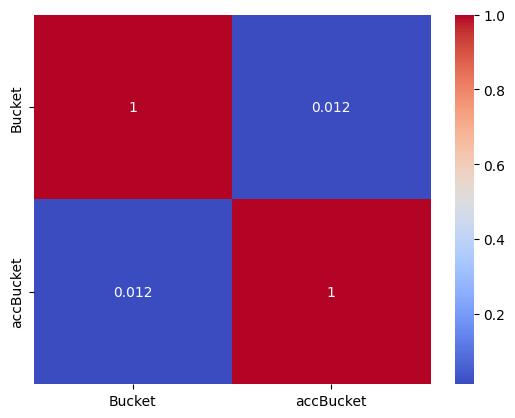

In [ ]:
numeric_col_dis = ['Bucket','accBucket']
startingDf_copy2 = cleanPedDf_copy
# Correlation Matrix formation
corr_matrix_dis = startingDf_copy2.loc[:,numeric_col_dis].corr()
# correlation_matrix = startingDf.corr()
sns.heatmap(corr_matrix_dis, annot=True, cmap='coolwarm')

In [ ]:

# plt.rc('font', size=20)
# plt.rc('axes', labelsize=20) #fontsize of the x and y labels
# plt.scatter(midEditedDf["speed"], midEditedDf["acceleration"], marker = ".")
# for pedId in allPedIds:
#     uniqueTrackId_collection[pedId] = midEditedDf[midEditedDf["uniqueTrackId"] == pedId].copy()
#     plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["acceleration"])
# plt.xlabel('Crossed Road Width (m)')
# plt.ylabel('Acceleration ($\mathregular{m/s^{2}}$)')
# plt.grid()
# # plt.savefig("MidAccelerationVsCrossedRoadWidth.png",bbox_inches="tight")
# plt.show()


NameError: name 'midEditedDf' is not defined

7600

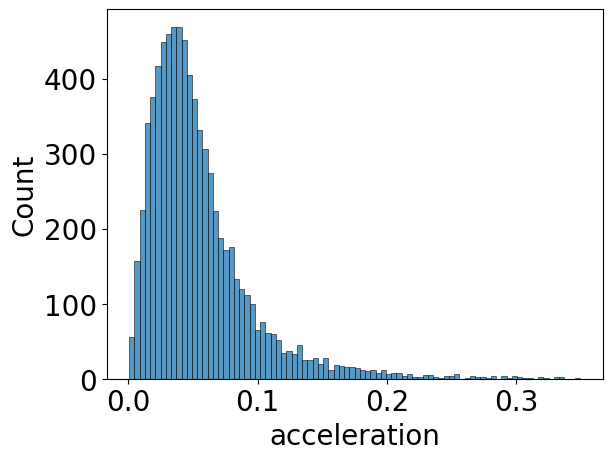

In [ ]:
sns.histplot(cleanPedDf_copy["acceleration"])
len(cleanPedDf_copy)

[[6.000e+00 7.000e+00 0.000e+00]
 [1.600e+01 8.600e+01 5.000e+00]
 [4.470e+02 2.865e+03 4.800e+01]
 [5.110e+02 3.370e+03 6.600e+01]
 [3.800e+01 1.100e+02 1.100e+01]
 [1.000e+00 9.000e+00 4.000e+00]]


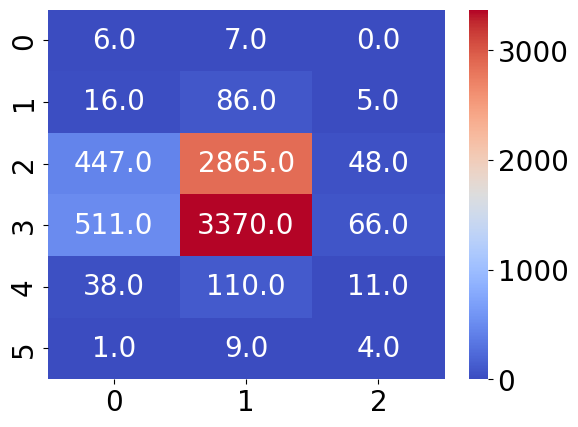

In [ ]:
# Generate some example data
plt.rc('font', size=20)
plt.rc('axes', labelsize=10) #fontsize of the x and y labels

NO_OF_BUCKETS = 3

data = np.zeros((2*NO_OF_BUCKETS, NO_OF_BUCKETS))

for index, row in cleanPedDf_copy.iterrows():
    data[cleanPedDf_copy.loc[index, "accBucket"]+NO_OF_BUCKETS][cleanPedDf_copy.loc[index, "Bucket"]] += 1
        
print(data)

# Create a heatmap using Seaborn
sns.heatmap(data, cmap='coolwarm', annot=True, fmt=".1f")

# Show the plot
plt.show()

In [ ]:
print(len(cleanPedDf_copy), len(cleanPedDf))

np.sum(data)

7600 7600


7600.0

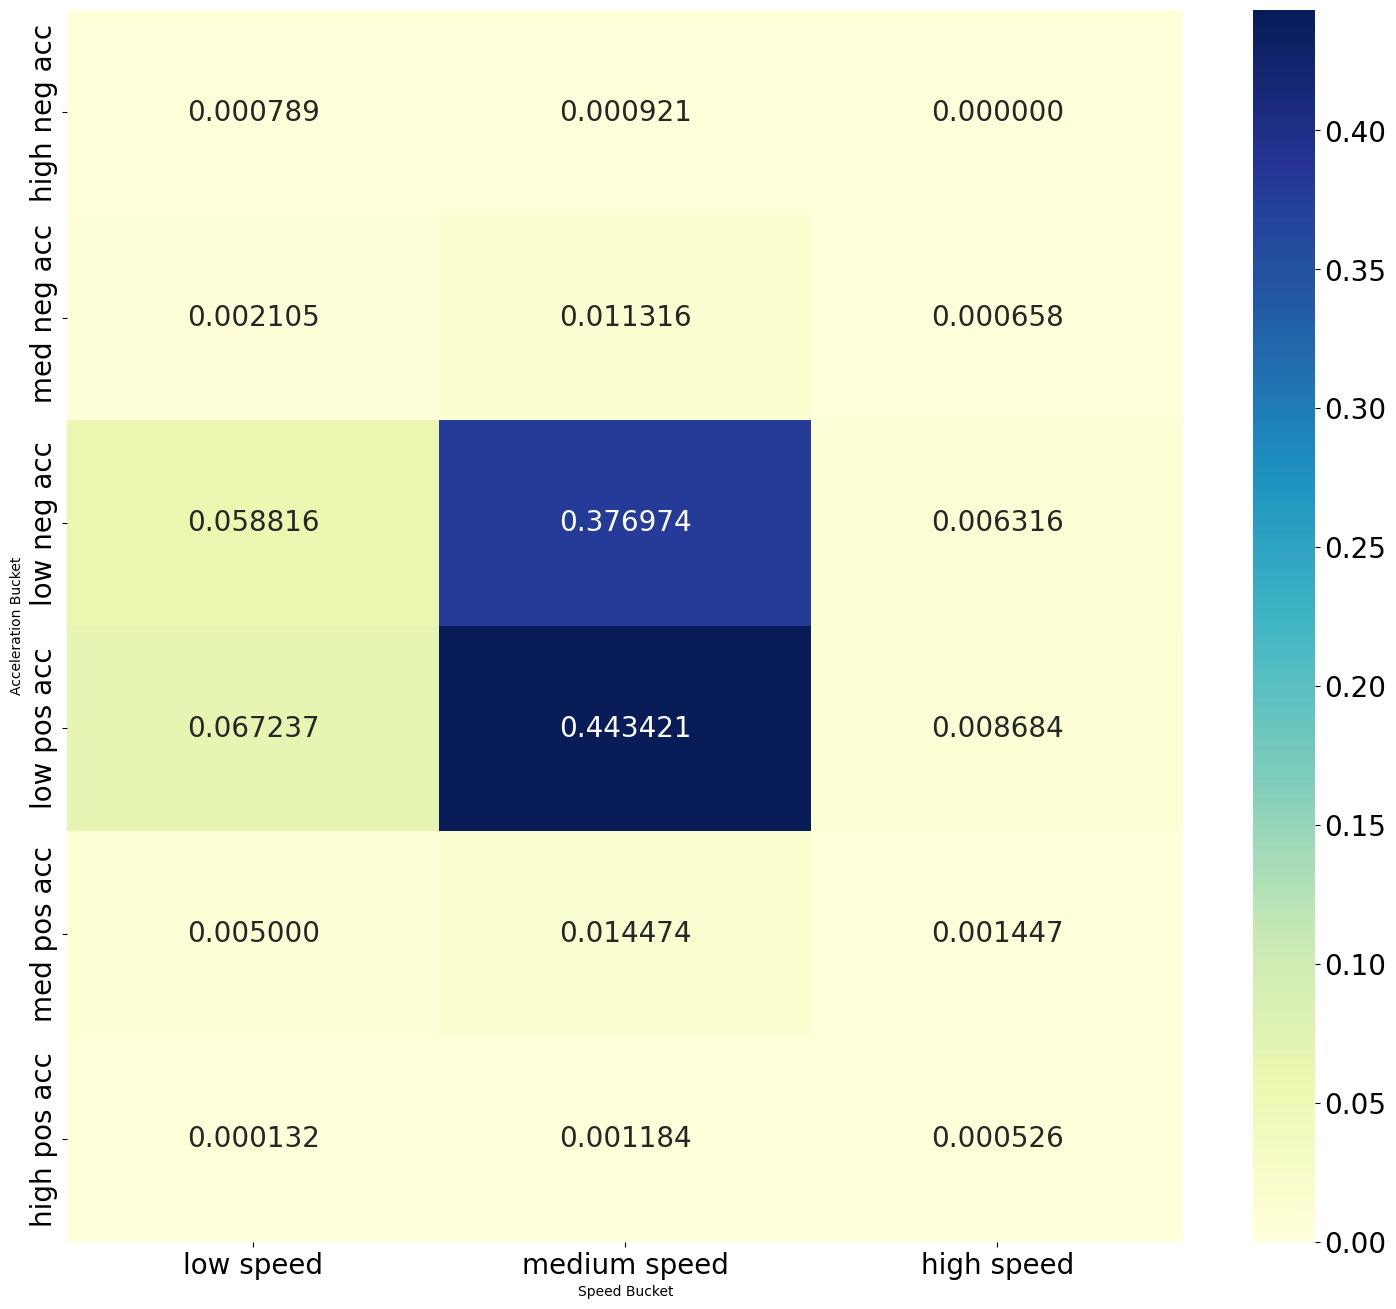

In [ ]:
# Generate example data
# data = np.random.rand(3, 3)

total_length = len(cleanPedDf_copy)
total_length

# Create a heatmap using Seaborn
plt.figure(figsize=(18, 16))
sns.heatmap(data/total_length, annot=True, fmt=".6f", cmap='YlGnBu')

# Customize the axis labels
plt.xlabel("Speed Bucket")
plt.ylabel("Acceleration Bucket")

# Customize the tick labels
x_labels = ["low speed", "medium speed", "high speed"]
y_labels = ["high neg acc", " med neg acc", "low neg acc", "low pos acc", "med pos acc", "high pos acc"]
plt.xticks(np.arange(0.5, NO_OF_BUCKETS + 0.5, 1), x_labels)
plt.yticks(np.arange(0.5, 2*NO_OF_BUCKETS + 0.5, 1), y_labels)

# # Customize the annotation format
# plt.gca().set_xticks(np.arange(3) + 0.5, minor=True)
# plt.gca().set_yticks(np.arange(3) + 0.5, minor=True)
# plt.gca().xaxis.set_tick_params(which="minor", size=0)
# plt.gca().yaxis.set_tick_params(which="minor", size=0)

# Show the plot
plt.show()


In [ ]:
min_value_speed = cleanPedDf_copy["speed"].min()
max_value_speed = cleanPedDf_copy["speed"].max()
value_range = max_value_speed - min_value_speed
category_range = value_range / NO_OF_CATEGORY
print(f"Speed cat Range = {category_range}")

min_value = cleanPedDf_copy["sceneYAcceleration"].min()
max_value = cleanPedDf_copy["sceneYAcceleration"].max()
# value_range = max_value - min_value
pos_category_range = max_value / NO_OF_CATEGORY
print(f"Pos Cat Range = {pos_category_range}")
neg_category_range = -(min_value) / NO_OF_CATEGORY
print(f"Neg Cat Range = {neg_category_range}")

tempDf = cleanPedDf_copy[(cleanPedDf_copy["speed"] > min_value_speed+category_range) & (cleanPedDf_copy["speed"] < min_value_speed+2*category_range) & (cleanPedDf_copy["sceneYAcceleration"] < pos_category_range) & (cleanPedDf_copy["sceneYAcceleration"] >= 0)]

Speed cat Range = 0.30947310850614834
Pos Cat Range = 0.07852426787155291
Neg Cat Range = 0.10898178797216956


In [ ]:
tempDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket,accBucket
27,18,804,18023,210,5.0,0.889504,-0.176444,-0.107957,0.499586,0.016608,0.028387,0.511117,0.260104,2.631298,0.032888,-0.260104,2.631298,1,0
28,18,806,18023,210,5.0,0.909839,-0.274597,-0.101676,0.490764,-0.031406,0.044112,0.501186,0.280439,2.729451,0.054150,-0.280439,2.729451,1,0
190,18,4194,18069,210,5.0,0.731066,1.500790,-0.115381,0.635455,-0.077176,0.000276,0.645845,0.101666,0.954064,0.077177,-0.232366,0.986353,1,0
191,18,4196,18069,210,5.0,0.752258,1.374259,-0.105959,0.632656,-0.047108,0.013996,0.641467,0.122858,1.080595,0.049143,-0.253558,1.112884,1,0
192,18,4198,18069,210,5.0,0.773376,1.248429,-0.105590,0.629149,-0.001845,0.017533,0.637948,0.143976,1.206425,0.017630,-0.274676,1.238714,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25882,29,28090,29534,210,5.0,0.626977,-1.565006,-0.171918,0.675933,-0.000436,0.000350,0.697454,0.002423,4.019860,0.000559,-0.874372,3.939596,1,0
25883,29,28092,29534,210,5.0,0.661564,-1.698682,-0.172934,0.668378,0.005078,0.037778,0.690387,0.032164,4.153535,0.038118,-0.908959,4.073271,1,0
25885,29,28096,29534,210,5.0,0.735649,-1.965220,-0.188894,0.662203,0.036809,0.041421,0.688618,0.106249,4.420074,0.055413,-0.983044,4.339810,1,0
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,1,0


In [ ]:
tempDf[tempDf["accBucket"] == 0]

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,Bucket,accBucket
27,18,804,18023,210,5.0,0.889504,-0.176444,-0.107957,0.499586,0.016608,0.028387,0.511117,0.260104,2.631298,0.032888,-0.260104,2.631298,1,0
28,18,806,18023,210,5.0,0.909839,-0.274597,-0.101676,0.490764,-0.031406,0.044112,0.501186,0.280439,2.729451,0.054150,-0.280439,2.729451,1,0
190,18,4194,18069,210,5.0,0.731066,1.500790,-0.115381,0.635455,-0.077176,0.000276,0.645845,0.101666,0.954064,0.077177,-0.232366,0.986353,1,0
191,18,4196,18069,210,5.0,0.752258,1.374259,-0.105959,0.632656,-0.047108,0.013996,0.641467,0.122858,1.080595,0.049143,-0.253558,1.112884,1,0
192,18,4198,18069,210,5.0,0.773376,1.248429,-0.105590,0.629149,-0.001845,0.017533,0.637948,0.143976,1.206425,0.017630,-0.274676,1.238714,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25882,29,28090,29534,210,5.0,0.626977,-1.565006,-0.171918,0.675933,-0.000436,0.000350,0.697454,0.002423,4.019860,0.000559,-0.874372,3.939596,1,0
25883,29,28092,29534,210,5.0,0.661564,-1.698682,-0.172934,0.668378,0.005078,0.037778,0.690387,0.032164,4.153535,0.038118,-0.908959,4.073271,1,0
25885,29,28096,29534,210,5.0,0.735649,-1.965220,-0.188894,0.662203,0.036809,0.041421,0.688618,0.106249,4.420074,0.055413,-0.983044,4.339810,1,0
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,1,0
